In [ ]:
#    Author  : Derek O'Sullivan
#    Date    : 14/08/23

#    Purpose : This creates a set of synth images on Google Drive for the train, validation and test folders

#    Adapted from https://github.com/hughfdjackson/fluorescent-fibre-counting.git

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
from random import randint
from random import random
from random import choice
from math import floor, pi, cos, sin, tanh, sqrt
import numpy as np
import itertools
from scipy.ndimage import gaussian_filter, filters, interpolation
from multiprocessing import Pool
from multiprocessing import set_start_method
from datetime import datetime
from uuid import uuid4
import os
from datetime import datetime
import cv2
from PIL import Image
from random import seed
import math
import matplotlib.pyplot as plt

In [43]:
class Component():
    """
        A component is some part of the generated image that knows
        how to draw itself.
    """

    def __init__(self, state):
        self.state = state

    @staticmethod
    def generate(config):
        """
            All randomness should be constrained to the this method; allowing
            the drawing of the images to be done in parallel.
        """
        pass

    def draw(self, image):
        return image

    def update_density_map(self, array):
        return array


def _generate_point(config, point, angle, rate_of_angle_change, curvature_sigma, curvature_limit):
    np.random.seed(_pick_natural(maximum = 1000))

    angle += rate_of_angle_change
    #rate_of_angle_change += np.random.normal(loc = 0, scale = curvature_sigma)
    rate_of_angle_change = np.random.normal(loc = 0, scale = curvature_sigma)

    rate_of_angle_change = np.clip(rate_of_angle_change, -pi * curvature_limit, pi * curvature_limit)


    vector = _vector(angle, 1)
    new_point = (point[0] + vector[0], point[1] + vector[1])

    return new_point, angle, rate_of_angle_change


def _generate_path(config, length, bounds):
    curvature_sigma = _pick_float(config.min_curvature_sigma, config.max_curvature_sigma)
    curvature_limit = _pick_float(config.min_curvature_limit, config.max_curvature_limit)
    start_ = (_pick_float(config.image_dims[0]), _pick_float(config.image_dims[1]))

    point = clip_within_border(start_, config)
    angle = (_pick_float(0, 2 * pi))
    rate_of_angle_change = 0
    path = [point]

    for length_so_far in range(length):
        point, angle, rate_of_angle_change = _generate_point(
            config,
            point,
            angle,
            rate_of_angle_change,
            curvature_sigma,
            curvature_limit)

        path.append(point)

    return path, length

def _clip_color_change_rate(rate_of_color_change):
    return np.clip(rate_of_color_change, -50, 50)

def _generate_segment_color(color_range, color, rate_of_color_change):
    np.random.seed(_pick_natural(maximum = 1000))

    color += rate_of_color_change
    color = int(np.clip(color, *color_range))
    rate_of_color_change += np.random.normal(loc = 0, scale = 30)
    rate_of_color_change = _clip_color_change_rate(rate_of_color_change)

    return color, rate_of_color_change

def _apply_end_colour_penality(i, length, color, alpha_range, amount):
    start = tanh(i / amount) * alpha_range[1]
    end = tanh(length - i / amount) * alpha_range[1]

    alpha = int(min(start, end))

    return color[:3] + (alpha,)

# def _generate_fibre_colors(length, color_range, alpha_range):
# # Trial of generating solid black lines for fibres
#     colors = [(0, 0, 0, 255)] * (length + 1)  # Generates a list of black color tuples
#     return colors


def _generate_colors(length, color_range, alpha_range):
    np.random.seed(_pick_natural(maximum = 1000))

    alpha = _pick_natural(*alpha_range)

#    color_bound_1 = _pick_natural(*color_range)
    color_bound_1 = _pick_natural(*color_range[:3])  # Use only RGB values
    color_bound_2 = np.clip(
        int(np.random.normal(loc = color_bound_1, scale = 200)),
        *color_range
    )

    color_bounds = (
        min([color_bound_1, color_bound_2]),
        max([color_bound_1, color_bound_2]),
    )

    penalty_amount = _pick_float(1, 2)

    color = _pick_natural(*color_bounds)

    color_with_penalty = _apply_end_colour_penality(0, length, _color(color, alpha), alpha_range, penalty_amount)


    colors = [color_with_penalty]
    rate_of_color_change = _clip_color_change_rate(_pick_natural(-50, 50))

    for i in range(length):
        color, rate_of_color_change = _generate_segment_color(color_bounds, color, rate_of_color_change)

        color_with_penalty = _apply_end_colour_penality(i + 1, length, _color(color, alpha), color_range, penalty_amount)
        colors.append(color_with_penalty)

    return colors

def _color(i, alpha = 255):
    return (i, i, i, alpha)

def _draw_fibre(state, image, isMask=False):
    image = state['bubble'].draw(image)
    path = state['path']

    draw = ImageDraw.Draw(image, 'RGBA')
    segments = zip(path[:-1], path[1:])

    if isMask == False:
        for segment, color in zip(segments, state['color']):
            draw.line(
                segment,
                fill = color,
                width = state['width']
            )
    else:

        color = generate_random_color()
        for segment in segments:
            draw.line(
                segment,
                #fill = color,
                fill = 255,
                width = state['width']
            )

    return image

def generate_random_color():
    # Line colours
    # red = randint(100, 220)
    # green = randint(100, 220)
    # blue = randint(100, 220)
    # alpha = 255

        # Return a solid white line
    red = 255
    green = 255
    blue = 255
    alpha = 255
    return (red, green, blue, alpha)



def _vector(angle, length):
    return (cos(angle) * length, sin(angle) * length)

class Fibre(Component):

    @staticmethod
    def generate(config):
        width = _pick_natural(config.min_fibre_width, config.max_fibre_width)
        max_length = _pick_natural(config.min_fibre_length, config.max_fibre_length)
        path, length = _generate_path(config, max_length, config.image_dims)

        return Fibre({
            'path': path,
            'color': _generate_colors(length, (100, 175), (200, 255)),
            #'color': _generate_colors(length, (125, 200), (150, 255)),
            'width': width,
            'bubble': FibreBubble.generate(path, width),
            'length': length,
            'image_dims': config.image_dims
        })

    def draw(self, image, isMask=False):
        return _draw_fibre(self.state, image, isMask)

    def update_density_map(self, array):
        def point_to_int(point):
            return (int(point[0]), int(point[1]))

        path = self.state['path']
        start = point_to_int(path[0])
        end = point_to_int(path[-1])

        if _point_is_within_bounds(start, array.shape):
            array[start[1], start[0]] += 1

        if _point_is_within_bounds(end, array.shape):
            array[end[1], end[0]] += 1

        return array

def _point_is_within_bounds(point, bounds):
    return (point[1] < bounds[0] and
            point[1] >= 0 and
            point[0] < bounds[1] and
            point[0] >= 0)

class NonFluorescentFibre(Component):
    """
        Fibres that are much darker than the fluorescent fibres in the image.
    """
    @staticmethod
    def generate(config):
        width = _pick_natural(config.min_fibre_width, config.max_fibre_width)
        max_length = _pick_natural(config.min_fibre_length, config.max_fibre_length)
        path, length = _generate_path(config, max_length, config.image_dims)

        return NonFluorescentFibre({
            'path': path,
            'color': _generate_colors(length, (0, 0), (255, 255)),
            #'color': _generate_fibre_colors(length, (0, 0), (255, 255)),
            'width': width,
            'bubble': FibreBubble.generate(path, width)
        })

    def draw(self, image, isMask=False):
        return _draw_fibre(self.state, image, isMask)

class FibreBubble(Component):

    @staticmethod
    def generate(path, width):
        return FibreBubble({
            'path': path,
            'width': floor(width * _pick_float(2.0, 7.0)),
            'alpha': _pick_natural(0, 3)
        })

    def draw(self, image):
        points = self.state['path']

        bubble_color = _color(255, self.state['alpha'])

        draw = ImageDraw.Draw(image, 'RGBA')
        draw.line(points, width = self.state['width'], fill = bubble_color)

        return image

_noise_shape = (2 ** 12), (2 ** 12)
_noise = np.random.normal(np.empty(_noise_shape)).repeat(3).reshape(_noise_shape + (3,))


class Background(Component):

    @staticmethod
    def generate(config):
        np.random.seed(_pick_natural(maximum = 324230432))

       # Get random background File
       #
        file_list = os.listdir(config.background_files_location)
        random_file = choice(file_list)
        file_path = os.path.join(config.background_files_location, random_file)
        image = Image.open(file_path).convert("RGBA")


        return Background({
            #'color': _color(_pick_natural(0, 50)),
            'color': _color(_pick_natural(200, 255)),  # Set background to white
            'bounding_box': [(0, 0), config.image_dims],
            'noise_degree': _pick_float(0, 5),
            'noise_shift': (_pick_natural(0, 100), _pick_natural(0, 100)),
            'image_dims': config.image_dims,
            'background_image': image
        })

    def draw(self, image):

        background_image = self.state['background_image'].resize(self.state['image_dims'])
        image.paste(background_image, (0, 0))

        # draw = ImageDraw.Draw(image, 'RGBA')
        # draw.rectangle(self.state['bounding_box'], fill = self.state['color'])

        # w, h = self.state['image_dims']
        # noise = np.roll(_noise[:h, :w, :], self.state['noise_shift'], axis = (0, 1))
        # noise *= self.state['noise_degree']

        # array = np.asarray(image).astype('float32')
        # array[:, :, :3] += noise
        # array = np.clip(array, 0, array.max())

        #return Image.fromarray(array.astype('uint8'))
        return image

class TapeLine(Component):

    @staticmethod
    def generate(config):
        w, h = config.image_dims

        angle = _pick_float(-pi, pi)

        # If we go this length in each direction from any starting point,
        # we're guaranteed to be outside of the image
        length_from_point = int(sqrt(w ** 2 + h ** 2))

        start_vec = _vector(angle, length_from_point)
        end_vec = _vector(angle, -length_from_point)

        xy = (_pick_natural(0, w), _pick_natural(0, h))

        start = _tuple_addition(xy, start_vec)
        end = _tuple_addition(xy, end_vec)

        num_segments = length_from_point * 2

        path = list(zip(
            np.linspace(start[0], end[0], num_segments),
            np.linspace(start[1], end[1], num_segments),
        ))

        # colors = _generate_colors(num_segments, (50, 150), (50, 50))
        colors = _generate_colors(num_segments, (0, 50), (50, 50))

        return TapeLine({
            'path': path,
            'colors': colors
        })

    def draw(self, image):
        draw = ImageDraw.Draw(image, 'RGBA')
        path = self.state['path']

        segments = zip(path[:-1], path[1:])

        for segment, color in zip(segments, self.state['colors']):
            draw.line(segment, fill = color)

        return image

def _tuple_addition(xs, ys):
    return tuple(x + y for x, y in zip(xs, ys))


class Blur(Component):

    @staticmethod
    def generate(config):
        return Blur({
            'radius': _pick_float(.5, 1.)
        })

    def draw(self, image):
         return image.filter(ImageFilter.GaussianBlur(radius = self.state['radius']))


class DensityMapBlur(Component):

    sigma = 1

    @staticmethod
    def generate(config):
        return DensityMapBlur({})

    def update_density_map(self, array):
        return gaussian_filter(array, sigma = self.sigma, mode = 'constant', cval = 0.0)


class Config:

    def __init__(self,
           background_files_location,
           #image_dims = (64, 64),
           image_dims = (1064, 1064),

           #max_fibres = 10, min_fibres = 1,
           max_fibres = 20, min_fibres = 1,
           max_fibre_width = 3, min_fibre_width = 1,
           max_fibre_length = 225, min_fibre_length = 20,
           max_background_fibres = 1, min_background_fibres = 0,
           min_curvature_sigma = .00, max_curvature_sigma = .05,
           min_curvature_limit = .025, max_curvature_limit = .15
       ):

        self.image_dims = image_dims
        self.max_fibres = max_fibres
        self.min_fibres = min_fibres
        self.max_fibre_width = max_fibre_width
        self.min_fibre_width = min_fibre_width
        self.max_fibre_length = max_fibre_length
        self.min_fibre_length = min_fibre_length
        self.max_background_fibres = max_background_fibres
        self.min_background_fibres = min_background_fibres
        self.min_curvature_sigma = min_curvature_sigma
        self.max_curvature_sigma = max_curvature_sigma
        self.min_curvature_limit = min_curvature_limit
        self.max_curvature_limit = max_curvature_limit
        self.background_files_location = background_files_location


def _pick_natural(minimum = 0, maximum = 1):
    return int(round(random() * (maximum - minimum)) + minimum)

def _pick_float(minimum = 0, maximum = 1.0):
    return (random() * (maximum - minimum)) + minimum


def clip_within_border(point, config):
    x, y = point
    w_, h_ = config.image_dims

    ## To avoid points on the edge of the image
    w, h = w_ - 5, h_ - 5
    return np.clip(x, 5, w), np.clip(y, 5, h)

def pick_fibre_number(config):
    return _pick_natural(config.min_fibres, config.max_fibres + 1)
    #return 1  # for initial tests, I'll have one fibre on each image


def gen_components(config):
    num_fibres = pick_fibre_number(config)
    #num_background_fibres = _pick_natural(config.min_background_fibres, config.max_background_fibres)

    background = Background.generate(config)

    fluorescent_fibres = [Fibre.generate(config) for i in range(num_fibres)]
    #background_fibres = [NonFluorescentFibre.generate(config) for i in range(num_background_fibres)]
    #fibres = (fluorescent_fibres + background_fibres)
    fibres = fluorescent_fibres
    fibres.sort(key = lambda x: random())
    tape_line = TapeLine.generate(config)

    blur = Blur.generate(config)
    density_map_blur = DensityMapBlur.generate(config)

    return [background] + fibres + [tape_line, blur, density_map_blur]

def create_fibre_image(components, config):
    image = Image.new('RGB', config.image_dims)

    for component in components:
        image = component.draw(image)

    return image.convert('L')

def create_fibre_mask(components, config):

    image_mask = Image.new('RGB', config.image_dims)
    for component in components:
        if isinstance(component, Fibre):
            image_mask = component.draw(image_mask, True)

    return image_mask.convert('L')

def create_density_map(components, config):
    w, h = config.image_dims
    array = np.zeros((h, w)) # for whatever reason, numpy prefers it in h -> w format

    for component in components:
        array = component.update_density_map(array)

    return array

def render_components(components, config):
    w, h = config.image_dims
    image = np.asarray(create_fibre_image(components, config)).reshape(h, w, 1)
    image_mask = np.asarray(create_fibre_mask(components, config)).reshape(h, w, 1)

    # Set pixels that are not black to fully white
    # Otherwise colab doesn't seem to sho wthem on the mask image
    # This behaviour is different from happens on local machine
    image_mask[image_mask != 0] = 255

    # density_map = np.asarray(create_density_map(components, config)).reshape(h, w, 1)
    #count = np.sum(density_map) / 2.
    count = 1

    return (image, image_mask, count)

def render_components_set(components_set, config):
#  Removing parallel processing due to issues with it on colab
#    with Pool() as p:
#        return p.starmap(render_components, zip(components_set, itertools.repeat(config)))
    return list(map(lambda args: render_components(*args), zip(components_set, itertools.repeat(config))))

def generate_training_example(config):
    return render_components(gen_components(config), config)

## Training set
def training_set(size, config):
    components_set = [gen_components(config) for i in range(size)]
    values = zip(*render_components_set(components_set, config))
    return tuple(np.array(v) for v in values)

In [44]:
def test_generation_is_deterministic(image_destination, mask_destination,background_images, numImages):

    #test_seed = 125
    #seed(test_seed)

    # Make images in groups of specified size
    image_groups = 5

    for i in range(math.ceil(numImages / image_groups)):
        print(f'Iteration {i} creating set of {image_groups} images' )
        data1, label1, count1 = training_set(image_groups, Config(background_images))

        for i, (image, mask) in enumerate(zip(data1, label1), 1):
            current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S-%f')
            Image.fromarray(image.squeeze(), mode="L").save(f"{image_destination}image_{current_time}.png")
            Image.fromarray(mask.squeeze(), mode="L").save(f"{mask_destination}mask_{current_time}.png")

In [45]:
#current_directory = os.getcwd()
#print('Current Directory', current_directory)
#parent_directory = os.path.dirname(current_directory)

parent_directory = '/content/drive/MyDrive/Colab Notebooks/FibreAnalysis'

# Set the start method to 'spawn'
# Remember to load backgrounds to google drive

# Create defined number of synthetic images
for stageDirectory, numberImages in [("Train", 2), ("Val", 1), ("Test", 1)]:

    background_images = os.path.join(parent_directory, 'Data', 'Backgrounds', '')
    sample_images = os.path.join(parent_directory, 'Data', 'synth', stageDirectory,'images', '')
    sample_masks = os.path.join(parent_directory, 'Data', 'synth',  stageDirectory, 'masks', '')

    print("Starting Image Creation")

    NumImages = 1
    test_generation_is_deterministic(sample_images , sample_masks , background_images, numberImages)
    print("Image Creation complete")

Starting Image Creation
Iteration 0 creating set of 5 images
Image Creation complete
Starting Image Creation
Iteration 0 creating set of 5 images
Image Creation complete
Starting Image Creation
Iteration 0 creating set of 5 images
Image Creation complete


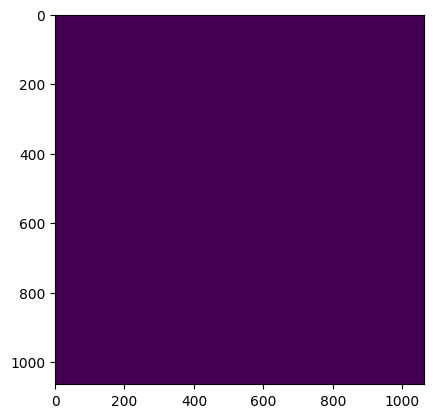

0


In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/synth/Train/masks/mask_2023-07-14_18-02-18-483537.png', cv2.IMREAD_GRAYSCALE)
   # Display the image
plt.imshow(img)
plt.show()

contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))